# OSHA Injuries

## I. Data Collection

In [31]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sny
import numpy as np
from IPython.display import display
from scipy.stats import fisher_exact
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Load Dataset
filepath = "/content/drive/MyDrive/Projects/OSHA_Injuries_Analytics/OSHA_Injuries_Construction_Dataset.csv"
df = pd.read_csv(filepath)

In [34]:
# Preview a sample of the data
df.head(1)

,summary_nr,Event Date,Abstract Text,Event Description,Event Keywords,con_end,Construction End Use,build_stor,Building Stories,proj_cost,...,Event type,evn_factor,Environmental Factor,hum_factor,Human Factor,task_assigned,Task Assigned,hazsub,fat_cause,fall_ht
0,220982664,8/10/2017,"At 9:00 a.m. on August 10, 2017, an employee w...",EMPLOYEE'S FINGERS AMPUTATED WHILE OPERATING A...,"FINGER,MECHANICAL POWER PRESS,AMPUTATION,GUARD",0,,0,,0,...,Caught in or between,2,Catch Point/Puncture Action,14,Other,1,Regularly Assigned,0,0,0


## II. Data Cleaning and Pre-processing

In [35]:
# Shape of the data
print(f"The data has {df.shape[0]} rows and {df.shape[1]} columns")

# Make a copy of the dataset
data = df.copy()

# Separate text columns
text_columns = ['Abstract Text', 'Event Description', 'Event Keywords']

# Remove unwanted columns
columns = ['Event Date', 'Abstract Text', 'Event Description',
       'Event Keywords', 'Degree of Injury', 'Nature of Injury',
       'Part of Body', 'Event type', 'Environmental Factor', 'Human Factor','Task Assigned']

df = df[columns]

# Preview a sample of the data
display(df.head(2))

# Check datatypes
print(df.info())

# Check summary statistics
df.describe()

The data has 4847 rows and 29 columns


,Event Date,Abstract Text,Event Description,Event Keywords,Degree of Injury,Nature of Injury,Part of Body,Event type,Environmental Factor,Human Factor,Task Assigned
0,8/10/2017,"At 9:00 a.m. on August 10, 2017, an employee w...",EMPLOYEE'S FINGERS AMPUTATED WHILE OPERATING A...,"FINGER,MECHANICAL POWER PRESS,AMPUTATION,GUARD",Nonfatal,"Amputation, Crushing",Fingers,Caught in or between,Catch Point/Puncture Action,Other,Regularly Assigned
1,7/17/2017,"At 9:45 a.m. on July 17, 2017, an employee was...",EMPLOYEE'S FINGER IS CAUGHT IN DRILL AND IS AM...,"CAUGHT IN,DRIVE SHAFT,RESIDENTIAL CONSTRUCTION...",Nonfatal,Dislocation,Fingers,Caught in or between,Other,Position Inappropriate For Task,Regularly Assigned


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Event Date            4847 non-null   object
 1   Abstract Text         4847 non-null   object
 2   Event Description     4847 non-null   object
 3   Event Keywords        4847 non-null   object
 4   Degree of Injury      4847 non-null   object
 5   Nature of Injury      4845 non-null   object
 6   Part of Body          4845 non-null   object
 7   Event type            4845 non-null   object
 8   Environmental Factor  4840 non-null   object
 9   Human Factor          4840 non-null   object
 10  Task Assigned         4847 non-null   object
dtypes: object(11)
memory usage: 416.7+ KB
None


,Event Date,Abstract Text,Event Description,Event Keywords,Degree of Injury,Nature of Injury,Part of Body,Event type,Environmental Factor,Human Factor,Task Assigned
count,4847,4847,4847,4847,4847,4845,4845,4845,4840,4840,4847
unique,671,4829,4320,4427,2,19,29,14,17,18,2
top,4/10/2017,"At 1:45 p.m. on January 9, 2017, an employee o...",EMPLOYEE FALLS FROM ROOF AND IS KILLED,HEART ATTACK,Fatal,Serious Fall/Strike,Head,Fall (from elevation),Other,Other,Regularly Assigned
freq,49,2,46,46,2964,1683,1023,1179,2009,1838,3048


In [36]:
# Count of missing values
df.isnull().sum()

,0
Event Date,0
Abstract Text,0
Event Description,0
Event Keywords,0
Degree of Injury,0
Nature of Injury,2
Part of Body,2
Event type,2
Environmental Factor,7
Human Factor,7


In [37]:
# Count of duplicates
df.duplicated().sum()

np.int64(0)

In [38]:
# Check rows with missing values
df[df.isnull().any(axis=1)]

,Event Date,Abstract Text,Event Description,Event Keywords,Degree of Injury,Nature of Injury,Part of Body,Event type,Environmental Factor,Human Factor,Task Assigned
888,3/14/2017,"At 4:00 p.m. on March 14, 2017, an employee wa...","EMPLOYEE SLIPS AND FALLS, FRACTURING LEG","SLIP,LEG,FRACTURE,FALL",Nonfatal,"Fracture, Broken Bones",Femur,Fall (same level),NaN,NaN,Regularly Assigned
909,3/13/2017,"At 10:00 a.m. on March 13, 2017, a 68 year old...",EMPLOYEE CAUGHT BETWEEN CRANE AND GATE RAIL IS...,"CAUGHT IN,CRANE",Fatal,"Fracture, Broken Bones",Hip,Caught in or between,Pinch Point Action,NaN,Regularly Assigned
1294,2/22/2017,"At approximately 1:30 p.m. on February 22, 201...",NO RECORDABLE INJURY,"BACKING UP,POWERED INDUSTRIAL VEHICLE",Nonfatal,NaN,NaN,NaN,NaN,NaN,Not Regularly Assigned
1660,2/3/2017,"At 12:00 a.m. on February 3, 2017, employees w...",EMPLOYEES EXPOSED TO ASBESTOS WHILE CLEANING U...,"NON-PEL OVEREXPOSURE,ASBESTOS",Nonfatal,NaN,NaN,NaN,NaN,NaN,Not Regularly Assigned
1724,2/1/2017,"At 8:15 a.m. on February 1, 2017, Employee #1,...",EMPLOYEE FALLS DOWN ELEVATOR SHAFT AND SUSTAIN...,"PELVIS,FRACTURE,RESIDENTIAL CONSTRUCTION,LUNG,...",Nonfatal,"Fracture, Broken Bones",Shoulder,Fall (from elevation),NaN,"Misjudgment, Hazardous Situation",Regularly Assigned
2451,11/29/2016,"On November 29, 2016, an employee was making c...",AN EMPLOYEE COLLAPSES AND DIES FROM UNKNOWN CAUSE,"CABLE TV WORK,COLLAPSE",Fatal,Serious Fall/Strike,Heart,Other,NaN,NaN,Not Regularly Assigned
2541,11/10/2016,"At 11:30 a.m. on November 2, 2016, an employee...",EMPLOYEE IS SEVERELY INJURED IN FALL WHILE TRI...,"TREE TRIMMING,ROPE,BRAIN,NECK,HEAD,FALL,SAW,RIB",Fatal,"Fracture, Broken Bones",Neck,Fall (from elevation),NaN,"Misjudgment, Hazardous Situation",Regularly Assigned
3394,6/3/2016,"At 8:15 p.m. on June 3, 2016, an employee was ...",EMPLOYEE FALLS FROM LADDER AND IS KILLED,"CRUSHING,FALL,HEAD,SCAFFOLD,LADDER,CONCRETE",Fatal,"Fracture, Broken Bones",Head,Fall (from elevation),NaN,NaN,Not Regularly Assigned
3402,5/31/2016,"At 6:00 p.m. on May 31, 2016, Employee #1 and ...",ONE EMPLOYEE KILLED AND ONE EMPLOYEE SHOCKED W...,"PUMP JACK SCAFFOLD,ELECTROCUTED,POWERED INDUST...",Fatal,Electrocution,Feet,Shock,Work-Surface/Facility-Layout Condition,NaN,Regularly Assigned


In [39]:
# Convert 'Event Date' to datetime
df['Event Date'] = pd.to_datetime(df['Event Date'])

# Add 'Month'
df['Month'] = df['Event Date'].dt.month_name()

# Add 'Year'
df['Year'] = df['Event Date'].dt.year

# Add 'YearMonth'
df['YearMonth'] = df['Event Date'].dt.to_period('M')

# Convert 'Event Date' to date
#df['Event Date'] = df['Event Date'].dt.date

# Check datatypes
df.dtypes

,0
Event Date,datetime64[ns]
Abstract Text,object
Event Description,object
Event Keywords,object
Degree of Injury,object
Nature of Injury,object
Part of Body,object
Event type,object
Environmental Factor,object
Human Factor,object


## III. Feature Engineering

In [40]:
# Detect holidays
import holidays
us_holidays = holidays.US()

# Add the 'Is_Holiday' column
df['Is_Holiday'] = df['Event Date'].apply(lambda x: x in us_holidays if pd.notnull(x) else False)

# Add the holiday name
df['Holiday'] = df['Event Date'].apply(lambda x: us_holidays.get(x) if pd.notnull(x) else None)

# Preview a sample of the data
df[df['Is_Holiday']==True].sample(2)

,Event Date,Abstract Text,Event Description,Event Keywords,Degree of Injury,Nature of Injury,Part of Body,Event type,Environmental Factor,Human Factor,Task Assigned,Month,Year,YearMonth,Is_Holiday,Holiday
2533,2016-11-11,"At 5:30 p.m. on November 11, 2016, an employee...",EMPLOYEE FALLS FROM LADDER AND IS KILLED,"FALL,LADDER",Fatal,"Fracture, Broken Bones",Internal Injuries,Fall (from elevation),Other,Other,Regularly Assigned,November,2016,2016-11,True,Veterans Day
2895,2016-09-05,"At approximately 11:30 a.m. on September 5, 20...",EMPLOYEE IS KILLED WHEN LOSING CONTROL OF A TR...,"OVERTURN,LOST CONTROL,TRACTOR TRAILER",Fatal,Serious Fall/Strike,Whole Body,Other,Other,Other,Not Regularly Assigned,September,2016,2016-09,True,Labor Day


In [41]:
# Add sesonalities
# Create a function that return seasons
def get_season(date):
    if pd.isnull(date):
        return None
    month = date.month
    day = date.day

    if (month == 12 and day >= 21) or (month <= 3 and (month != 3 or day < 20)):
        return 'Winter'
    elif (month == 3 and day >= 20) or (month <= 6 and (month != 6 or day < 21)):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month <= 9 and (month != 9 or day < 22)):
        return 'Summer'
    elif (month == 9 and day >= 22) or (month <= 12 and (month != 12 or day < 21)):
        return 'Fall'
    else:
        return 'Winter'

df['Season'] = df['Event Date'].apply(get_season)

# Preview a sample of the data
df.sample(2)

,Event Date,Abstract Text,Event Description,Event Keywords,Degree of Injury,Nature of Injury,Part of Body,Event type,Environmental Factor,Human Factor,Task Assigned,Month,Year,YearMonth,Is_Holiday,Holiday,Season
4510,2015-09-10,"At 12:00 a.m. on September 10, 2015, Employee ...",EMPLOYEE DIES FROM HEART ATTACK,HEART ATTACK,Fatal,Serious Fall/Strike,Ribs,Card-vascular/resp. fail.,Other,Other,Not Regularly Assigned,September,2015,2015-09,False,None,Summer
3530,2016-05-02,"At 3:15 p.m. on May 2, 2016, and employee was ...",EMPLOYEE IS KILLED WHEN ARM IS CAUGHT IN CONVEYER,"CAUGHT IN,ASPHYXIATED,CONVEYOR,LOCKOUT/TAGOUT",Fatal,"Asphyxiation, Drowning",Neck,Caught in or between,Other,Insufficient /Lack/Written Work Practice Program,Not Regularly Assigned,May,2016,2016-05,False,None,Spring


## IV. Exploratory Data Analysis

##### **1. Injury Patterns in Construction**



,Counts,Percentages
Degree of Injury,,
Fatal,2964,61.151228
Nonfatal,1883,38.848772


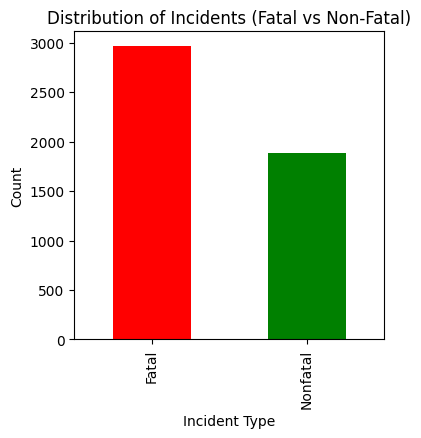

❌ The percentage of Fatal is:  61.15%
✅ The percentage of Non-Fatal is: 38.85%


In [42]:
# ---------- Percentage of all incidents that result in fatalities ----------
# a. Percentages
counts = df['Degree of Injury'].value_counts()
percentages = counts / counts.sum() * 100

# Create a dataframe
incidents = pd.DataFrame({'Counts': counts, 'Percentages': percentages})

# Display the dataframe
display(incidents)

# b. Distribution of incidents (fatal vs non-fatal) using a bar chart
plt.figure(figsize=(4,4))
incidents['Counts'].plot(kind='bar', color=['red', 'green'])
plt.title('Distribution of Incidents (Fatal vs Non-Fatal)')
plt.xlabel('Incident Type')
plt.ylabel('Count')
plt.show()

print(f"❌ The percentage of Fatal is:  {round(incidents.loc['Fatal', 'Percentages'], 2)}%")
print(f"✅ The percentage of Non-Fatal is: {round(incidents.loc['Nonfatal', 'Percentages'], 2)}%")

The top 3 common types of injuries are: ['Serious Fall/Strike', 'Fracture, Broken Bones', 'Amputation, Crushing']


,Counts,Percentages
Nature of Injury,,
Serious Fall/Strike,1683,34.736842
"Fracture, Broken Bones",852,17.585139
"Amputation, Crushing",542,11.186791
Laceration,382,7.884417
Head Trauma,328,6.769866
"Bruising, Contusion",291,6.006192
"Asphyxiation, Drowning",213,4.396285
Electrocution,199,4.107327
Fire Burn,144,2.972136


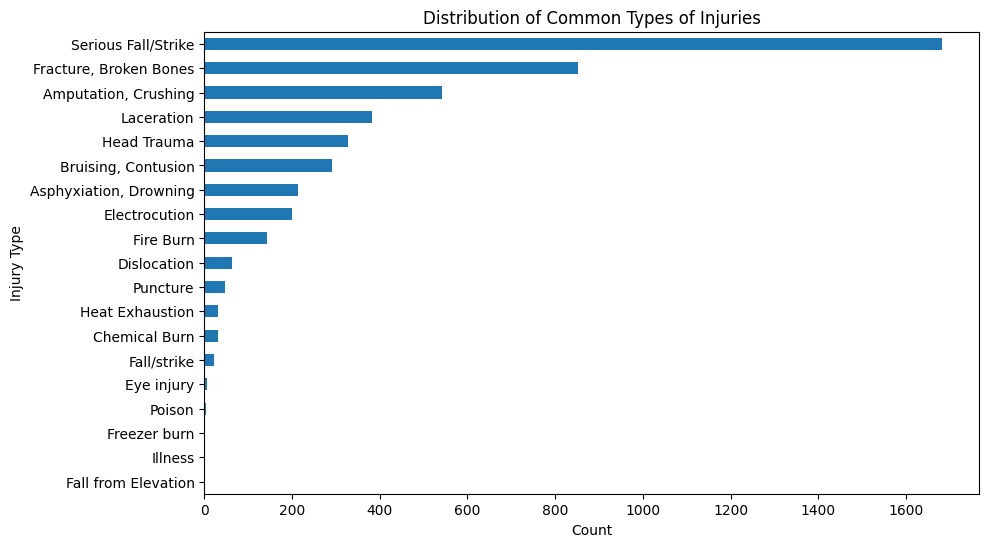

In [43]:
# ---------- Most Common Types of Injuries  ----------
# a. Percentages
counts = df['Nature of Injury'].value_counts()
percentages = counts / counts.sum() * 100

# Create a Dataframe
injuries_types = pd.DataFrame({'Counts': counts, 'Percentages': percentages})

# Print the top 3 common types of types
print(f"The top 3 common types of injuries are: {injuries_types.head(3).index.tolist()}")

# Display the dataframe
display(injuries_types)

# b. Distribution of common types of injuries
plt.figure(figsize=(10,6))
injuries_types['Counts'].sort_values(ascending=True).plot(kind='barh')
plt.title('Distribution of Common Types of Injuries')
plt.xlabel('Count')
plt.ylabel('Injury Type')
plt.show()

##### **2. Fatality Analysis**

The top three injuries most likely to result in a fatality are: ['Fall from Elevation', 'Asphyxiation, Drowning', 'Serious Fall/Strike']


,sum,count,percentage
Nature of Injury,,,
Fall from Elevation,1,1,100.00
"Asphyxiation, Drowning",204,213,95.77
Serious Fall/Strike,1517,1683,90.14
Electrocution,173,199,86.93
Heat Exhaustion,27,32,84.38
Head Trauma,234,328,71.34
"Bruising, Contusion",171,291,58.76
Puncture,26,48,54.17
Dislocation,32,64,50.00


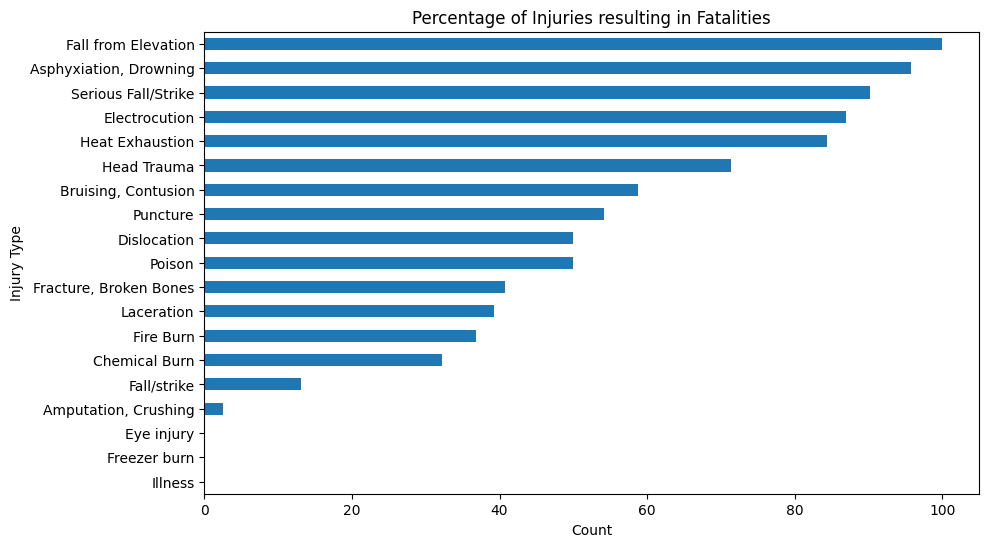

In [44]:
# ---------- Percentage of injuries resulting in Death  ----------
# a. Percentages
df['Is_Fatal'] = df['Degree of Injury'].apply(lambda x:1 if x == 'Fatal' else 0)

# Group Fatalieis by 'Nature of Injury'
fatalities_by_injuries = df.groupby('Nature of Injury')['Is_Fatal'].agg(['sum','count'])
fatalities_by_injuries['percentage'] = round((fatalities_by_injuries['sum'] / fatalities_by_injuries['count']) * 100, 2)
fatalities_by_injuries.sort_values('percentage', ascending=False, inplace=True)

# Top 3 injuries most likely to result in a fatality
print(f"The top three injuries most likely to result in a fatality are: {fatalities_by_injuries.head(3).index.tolist()}")

# Display the dataframe
display(fatalities_by_injuries)

# b. Percentage of Injuries resulting in Death
plt.figure(figsize=(10,6))
fatalities_by_injuries['percentage'].sort_values(ascending=True).plot(kind='barh')
plt.title('Percentage of Injuries resulting in Fatalities')
plt.xlabel('Count')
plt.ylabel('Injury Type')
plt.show()

Environmental Factor : The top three factors most likely to result in a fatality are: ['Illumination', 'Overhead Moving/Falling Object Action', 'Flammable Liquid/Solid Exposure']


,sum,count,percentage
Environmental Factor,,,
Illumination,30,34,88.24
Overhead Moving/Falling Object Action,244,320,76.25
Flammable Liquid/Solid Exposure,24,33,72.73
Other,1435,2009,71.43
Overpressure/Underpressure,35,51,68.63
Work-Surface/Facility-Layout Condition,400,608,65.79
"Weather, Earthquake, Etc.",66,105,62.86
Materials Handling Equip./Method,398,635,62.68
Temperature +/- Tolerance Lev.,45,73,61.64


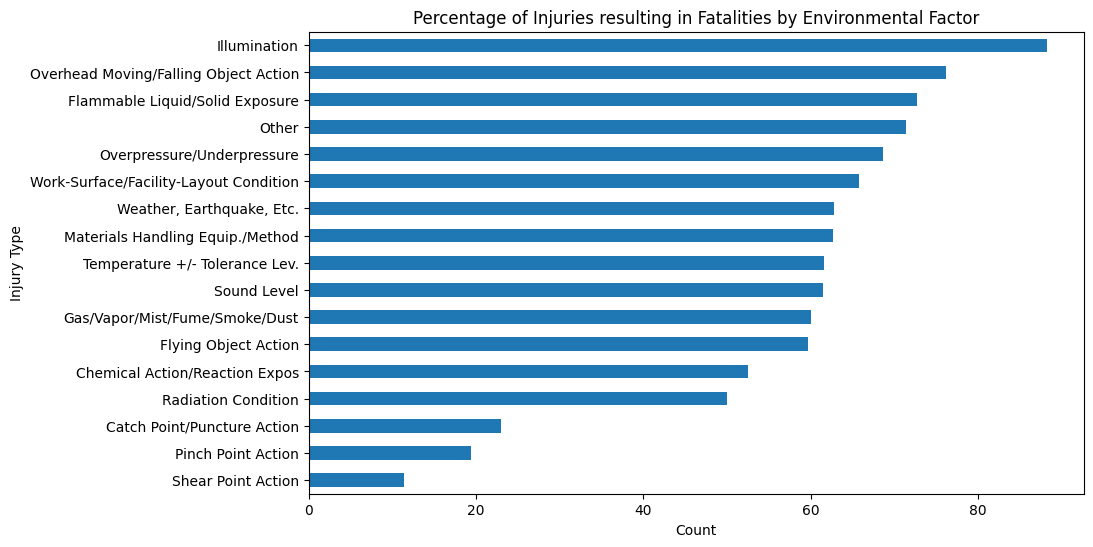

Human Factor : The top three factors most likely to result in a fatality are: ['Insufficient /Lack/Respiratory Protection', 'Insufficient /Lack/Expose/Biological Monitoring.', 'Other']


,sum,count,percentage
Human Factor,,,
Insufficient /Lack/Respiratory Protection,12,12,100.00
Insufficient /Lack/Expose/Biological Monitoring.,1,1,100.00
Other,1270,1838,69.10
Malfunction Neuromuscular System,9,14,64.29
Insufficient /Lack/Protective Work Clothing/Equipment,96,151,63.58
Perception Malfunction Task-Environment,24,39,61.54
Malfunction In Securing/Warning Op,65,106,61.32
Equipment Inappropriate For Operation,85,142,59.86
Distracting Actions By Others,24,41,58.54


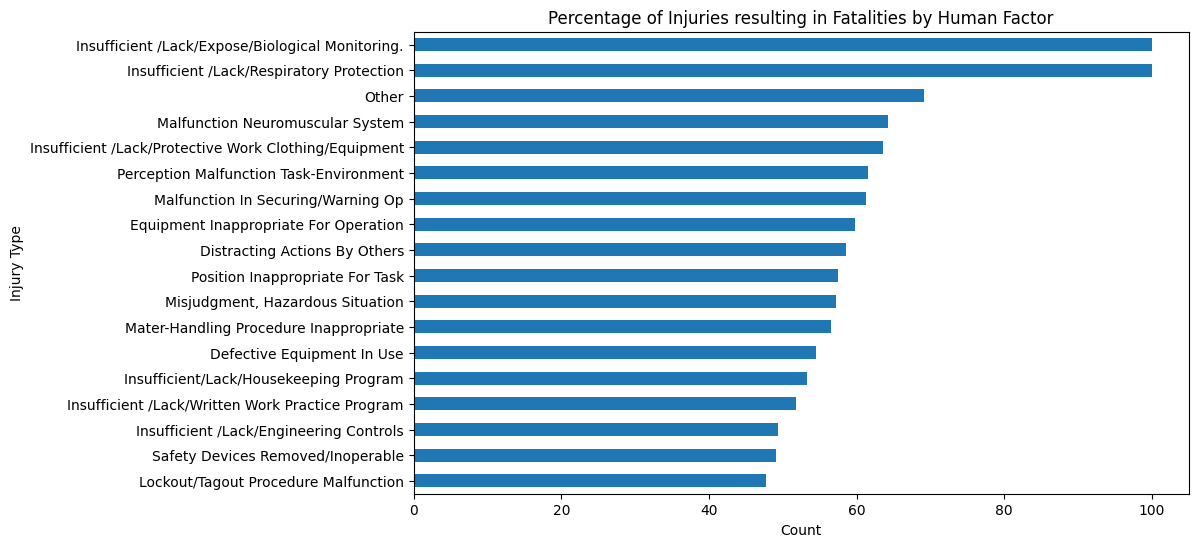

Task Assigned : The factor most likely to result in a fatality is: ['Not Regularly Assigned']


,sum,count,percentage
Task Assigned,,,
Not Regularly Assigned,1188,1799,66.04
Regularly Assigned,1776,3048,58.27


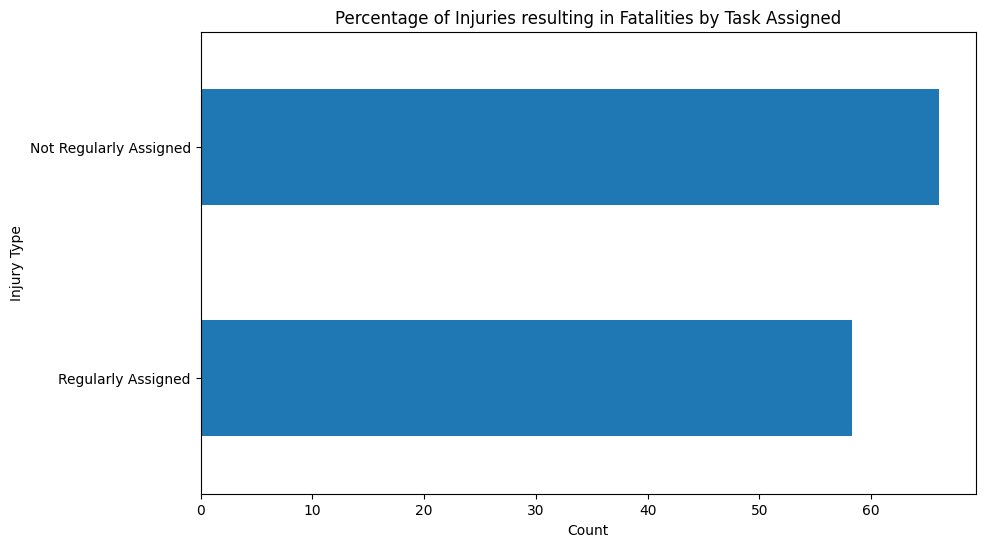

In [45]:
# ---------- Factors associated with Fatalities (environmental, human, task assignment)  ----------
# a. Percentages
factors = ['Environmental Factor', 'Human Factor', 'Task Assigned']

for factor in factors:

  # Group by fatalities
  fatalities_by_factor = df.groupby(factor)['Is_Fatal'].agg(['sum', 'count'])
  fatalities_by_factor['percentage'] = round((fatalities_by_factor['sum'] / fatalities_by_factor['count']) * 100, 2)
  fatalities_by_factor.sort_values('percentage', ascending=False, inplace=True)

  # Top 3 injuries most likely to result in a fatality
  if factor == 'Task Assigned':
    print(f"{factor} : The factor most likely to result in a fatality is: {fatalities_by_factor.head(1).index.tolist()}")
  else:
    print(f"{factor} : The top three factors most likely to result in a fatality are: {fatalities_by_factor.head(3).index.tolist()}")

  # Display the dataframe
  display(fatalities_by_factor)

# b. Plotting the percentages
  plt.figure(figsize=(10,6))
  fatalities_by_factor['percentage'].sort_values(ascending=True).plot(kind='barh')
  plt.title(f'Percentage of Injuries resulting in Fatalities by {factor}')
  plt.xlabel('Count')
  plt.ylabel('Injury Type')
  plt.show()

In [46]:
df.sample(2)

,Event Date,Abstract Text,Event Description,Event Keywords,Degree of Injury,Nature of Injury,Part of Body,Event type,Environmental Factor,Human Factor,Task Assigned,Month,Year,YearMonth,Is_Holiday,Holiday,Season,Is_Fatal
1772,2017-01-30,"At 5:30 p.m. on January 30, 2017, an employee ...",EMPLOYEE SUSTAINS A FRACTURED LEFT TOE WHEN OP...,"TOE,FRACTURE,MATERIAL HANDLING,CAUGHT BETWEEN",Nonfatal,"Fracture, Broken Bones",Feet,Caught in or between,Materials Handling Equip./Method,"Misjudgment, Hazardous Situation",Regularly Assigned,January,2017,2017-01,False,None,Winter,0
1829,2017-01-26,"At 10:00 a.m. on January 26, 2017, two employe...",TWO EMPLOYEES ARE INJURED IN FLASH FIRE,"SHIPYARD,EXPLOSION,PORTABLE POWER TOOL,FIRE,BU...",Nonfatal,Fire Burn,Face,Other,Gas/Vapor/Mist/Fume/Smoke/Dust,Other,Not Regularly Assigned,January,2017,2017-01,False,None,Winter,0


##### **3. Trend Analysis**

,Count of Injuries,YearMonth
YearMonth,,
2016-04,143,2016-04
2016-03,131,2016-03
2016-01,117,2016-01
2016-07,170,2016-07
2017-03,586,2017-03


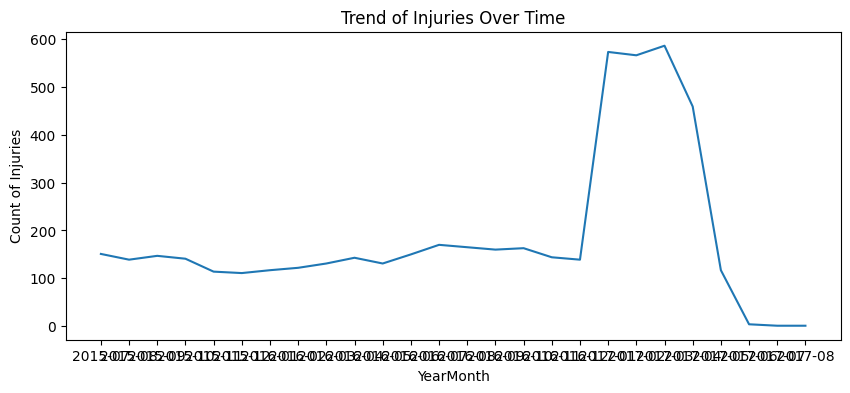

In [47]:
# ---------- Trends of incidents and injuries  ----------
# a. Line Chart of injuries count over time
monthly_trend = df.groupby('YearMonth')['Nature of Injury'].agg(['count'])
monthly_trend['Count of Injuries'] = monthly_trend['count']
monthly_trend['YearMonth'] = monthly_trend.index

# Drop other columns
monthly_trend.drop(columns=['count'], inplace=True)

display(monthly_trend.sample(5))


plt.figure(figsize=(10,4))
plt.plot(monthly_trend['YearMonth'].astype(str), monthly_trend['Count of Injuries'])
plt.title('Trend of Injuries Over Time')
plt.xlabel('YearMonth')
plt.ylabel('Count of Injuries')
plt.show()


##### **4. Risk Distribtuion**

The top three body parts most likely to result in a fatality are: ['Whole Body', 'Heart', 'Internal Injuries']


,sum,count,percentage
Part of Body,,,
Whole Body,522,555,94.05
Heart,330,374,88.24
Internal Injuries,352,403,87.34
Head,881,1023,86.12
Abdomen,69,81,85.19
Ribs,255,305,83.61
Neck,130,157,82.80
Lungs (Puncture),75,106,70.75
Lungs (Asphyxiation),14,20,70.00


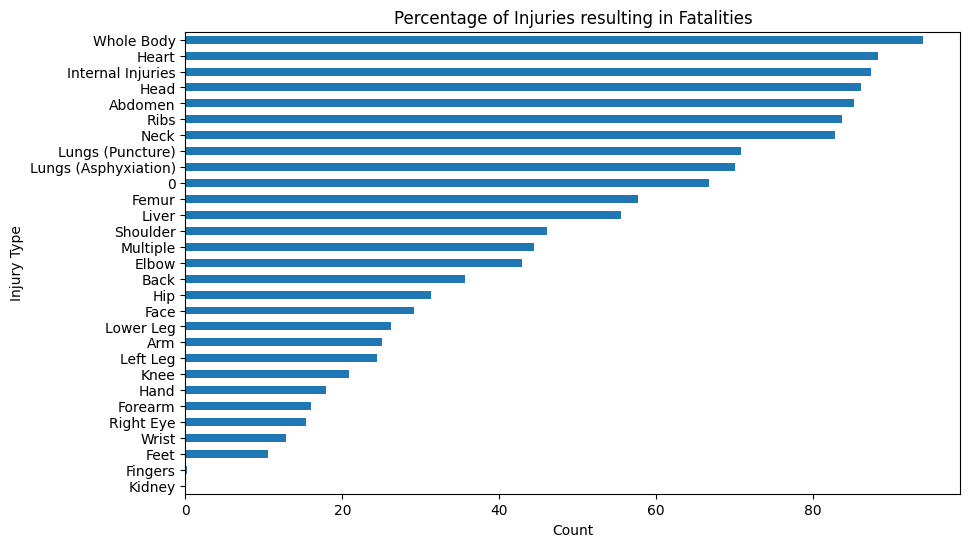

In [48]:
# ---------- Body parts most commonly injured  ----------
# a. Percentages
# Group Fatalities by 'Body Parts' involved
fatalities_by_parts = df.groupby('Part of Body')['Is_Fatal'].agg(['sum','count'])
fatalities_by_parts['percentage'] = round((fatalities_by_parts['sum'] / fatalities_by_parts['count']) * 100, 2)
fatalities_by_parts.sort_values('percentage', ascending=False, inplace=True)

# Top 3 body parts most likely to result in a fatality
print(f"The top three body parts most likely to result in a fatality are: {fatalities_by_parts.head(3).index.tolist()}")

# Display the dataframe
display(fatalities_by_parts)

# b. Percentage of Injuries resulting in Death
plt.figure(figsize=(10,6))
fatalities_by_parts['percentage'].sort_values(ascending=True).plot(kind='barh')
plt.title('Percentage of Injuries resulting in Fatalities')
plt.xlabel('Count')
plt.ylabel('Injury Type')
plt.show()

## V. Explanatory Data Analytics

##### **1. A/B Testing using Fisher's Exact Test**

In [49]:
# Is the proportion of fatal injuries significantly higer on holidays?
# Group A = Holdiday incidents
# Group B = Non-holiday incidents
# Outcome = Proportion of fatalities in each group

# Create the contingency table
contingency = pd.crosstab(df['Is_Holiday'], df['Is_Fatal'])

display(contingency)

# Run Fisher's exact test
table = [
      [contingency.loc[True, 0], contingency.loc[True, 1]], # Holidays
    [contingency.loc[False, 0], contingency.loc[False, 1]] # Non-Holidays

]

odds_ratio, p_value = fisher_exact(table, alternative='two-sided')

print(f"Odds Ratio: {odds_ratio}")
print(f"P-value: {p_value}")

Is_Fatal,0,1
Is_Holiday,,
False,1842,2916
True,41,48


Odds Ratio: 1.352198697068404
P-value: 0.18744780236439249


- Odds ration tells us how much more (or less) likely fatalities are on holidays vs non-holidays.
- P-value tells us wether that difference is statistically significant.
- If P-value < 0.05: we have statistical evidence that the fatality rate differs between holidays and non-holidays.
- odds_ratio > 1: Higher odds of fatality on holidays.
- odds_ratio < 1: Lower odds of fatality on holidays.

Based on Fisher's Exact Test, there is no statistically significant difference in the fatality rate between holiday and non-holiday incidents (p = 0.18).
While the odds of fatality appear 35% higher on holidays (OR = 1.35), this difference is not strong enough to rule out chance due to sample size or variability.

##### **2. Logistic Regression for Fatality Prediction**

In [50]:
df.columns


Index(['Event Date', 'Abstract Text', 'Event Description', 'Event Keywords',
       'Degree of Injury', 'Nature of Injury', 'Part of Body', 'Event type',
       'Environmental Factor', 'Human Factor', 'Task Assigned', 'Month',
       'Year', 'YearMonth', 'Is_Holiday', 'Holiday', 'Season', 'Is_Fatal'],
      dtype='object')

In [53]:
# Select features and target
features = ['Nature of Injury', 'Part of Body', 'Event type',
            'Environmental Factor', 'Human Factor', 'Task Assigned', 'Is_Holiday', 'Season']
target = 'Degree of Injury'

# Step 1: Subset relevant data
df_model = df[features + [target]].dropna()

# Step 2: Convert target to binary (if not already 0/1)
df_model[target] = df_model[target].apply(lambda x: 1 if x == 'Fatal' else 0)

# Step 3: Encode categorical variables
df_encoded = pd.get_dummies(df_model, drop_first=True)

# Step 4: Split features and target
X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.85      0.86       373
           1       0.91      0.92      0.91       595

    accuracy                           0.89       968
   macro avg       0.89      0.89      0.89       968
weighted avg       0.89      0.89      0.89       968

[[318  55]
 [ 48 547]]


In [56]:
# Create DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

# Sort by absolute value of coefficient (impact)
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display top features
importance_df[['Feature', 'Coefficient']].sort_values(by='Coefficient', ascending=False)


,Feature,Coefficient
1,"Nature of Injury_Asphyxiation, Drowning",2.460531
29,Part of Body_Head,2.142821
45,Part of Body_Whole Body,2.022478
32,Part of Body_Internal Injuries,1.920026
41,Part of Body_Neck,1.738410
...,...,...
27,Part of Body_Forearm,-1.602939
28,Part of Body_Hand,-1.708370
94,Season_Spring,-1.942505
96,Season_Winter,-2.818762


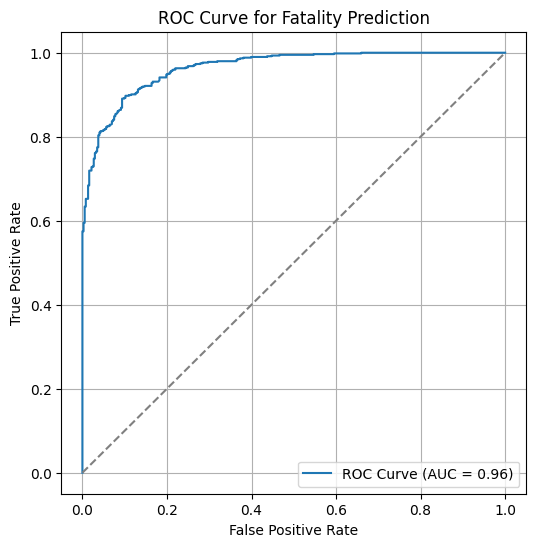

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fatality Prediction')
plt.legend()
plt.grid(True)
plt.show()


## VI. References